# Embeddings
We saw in our previous notebook that the one-hot vectors and the bag-of-word-vectors were very sparse (i.e. they had a lot of zeros), and thus didn't contain much information. In particular, every word has the same distance to all other words in one-hot encodings. We would gain a lot if we are able to encode our words such that similar words are close together.

## Prepare Data

We start by downloading the data and preparing it for our purposes.

In [1]:
url = "https://raw.githubusercontent.com/mattminder/nlp_intro/refs/heads/main/data/sms_spam_collection/SMSSpamCollection"

import pandas as pd
import urllib.request
data = urllib.request.urlopen(url)

# directly load the file from github for compatability with Colab
lines_split = [
    line.decode().strip().split("\t")
    for line in data
]
df = pd.DataFrame(lines_split, columns=["label", "text"])

We do tokenization and stemming in the same way as before:

In [2]:
def remove_punctuation(text):
    for letter in '".,;:!?()_*':
        text = text.replace(letter, " ")  # replace with a space
    return text

def rudimentary_stemming(word_list):
    suffixes_to_remove = [
        "s",  # plural suffix
        "ing",
        "ed",
    ]
    def remove_suffixes(word):
        for suffix in suffixes_to_remove:
            word = word.removesuffix(suffix)
        return word

    return [
        remove_suffixes(word)
        for word in word_list
    ]

def preprocessing(text):
    lower_case = text.lower()
    without_punctuation = remove_punctuation(lower_case)
    tokens = without_punctuation.split()  # splits at any whitespace
    after_stemming = rudimentary_stemming(tokens)
    return after_stemming

df["word_list"] = df["text"].apply(preprocessing)


Again, we create a dictionary that maps frequent words to a number. 

In [3]:
def get_frequent_word_dictionary(word_list, minimum_count=10):
    """Create a mapping from frequent words to an integer."""
    # create a dictionary with the number of occurrences of every word
    word_count = pd.Series(word_list).value_counts().to_dict()

    # identify the set of words that are frequent enough
    relevant_words = {
        word for word, count in word_count.items() if count >= minimum_count
    }

    # turn that set into a dictionary
    return {
        word: i
        for i, word in enumerate(relevant_words)
    }


frequent_word_dictionary = get_frequent_word_dictionary(
    [e for row in df["word_list"].to_list() for e in row]
)

vocabulary_size = len(frequent_word_dictionary) + 1

# this time we assign the last number to unknown words
df["word_number_list"] = df["word_list"].apply(
    lambda word_list: [
        frequent_word_dictionary.get(word, vocabulary_size)
        for word in word_list
    ]
)

In [4]:
# We want to keep texts with more than three words
keep = df["word_number_list"].apply(len) > 3
df = df[keep]

## Skip-Gram Model
One way to calculate such an encoding is to use a skip-gram model. It takes a word and wants to predict all words surrounding the input word in a given sentence.

For example in the sentence:
"I go out to *take* *the* **dog** *for* *a* walk".

If we provide the word **dog** as an input, we would want to correctly predict all the words marked in italic.

In [5]:
import torch

class SkipGram(torch.nn.Module):

    def __init__(self, vocabulary_size, embedding_dim):
        super().__init__()

        # We randomly initialize two matrices, embedding and context
        self.embedding_matrix = torch.nn.Parameter(
            torch.randn(size=(vocabulary_size, embedding_dim))
        )
        self.context_matrix = torch.nn.Parameter(
            torch.randn(size=(embedding_dim, vocabulary_size))
        )

        # in the end, we calculate Softmax according to the last axis

    def forward(self, x):
        emb = x @ self.embedding_matrix
        return emb @ self.context_matrix


Next, we have to define how we load data:

In [6]:
import random
import functools

class SkipGramData(torch.utils.data.Dataset):

    def __init__(self, df, vocabulary_size):
        self.df = df
        self.vocabulary_size = vocabulary_size

    def _number_to_one_hot(self, number):
        return torch.nn.functional.one_hot(torch.Tensor([number]).long(), self.vocabulary_size).float()

    def __getitem__(self, idx):
        row_ix = idx % len(self.df)
        word_number_list = self.df["word_number_list"].iloc[row_ix]

        # we randomly choose an input and target word, at most 2 words apart
        word_number = random.sample(range(len(word_number_list)), 1)[0]

        query = word_number_list[word_number]

        targets = [
            self._number_to_one_hot(word_number_list[word_number + delta])
            for delta in [-2, -1, 1, 2]
            if word_number + delta >= 0 and word_number + delta < len(word_number_list)
        ]
        target = functools.reduce(lambda x, y: x + y, targets)
        target = torch.clip(target, 0, 1)

        return (
            self._number_to_one_hot(query),
            target,
        )

    def __len__(self):
        return len(self.df)


Split into training and validation data:

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=.2, random_state=123)

Defining the model and the data loaders:

In [8]:
skip_gram_train_data = SkipGramData(train, vocabulary_size + 1)
skip_gram_test_data = SkipGramData(test, vocabulary_size + 1)

def my_collate(batch):
    queries, targets = zip(*batch)
    return torch.concat(queries), torch.concat(targets)

# load data in batches
train_data_loader = torch.utils.data.DataLoader(
    skip_gram_train_data,
    batch_size=32,
    shuffle=True,
    collate_fn=my_collate
)
test_data_loader = torch.utils.data.DataLoader(
    skip_gram_test_data,
    batch_size=32,
    shuffle=True,
    collate_fn=my_collate
)

Training the model:

In [9]:
# we embed into two dimensions only
skip_gram_model = SkipGram(vocabulary_size + 1, 2)
optimizer = torch.optim.AdamW(skip_gram_model.parameters(), lr=.001)

n_epochs = 200
train_losses = []
val_losses = []

for i in range(n_epochs):
    # train during a single epoch
    train_loss_epoch = []
    for queries, targets in train_data_loader:
        optimizer.zero_grad()

        outputs = skip_gram_model(queries)

        loss = torch.nn.functional.cross_entropy(outputs, targets)
        loss.backward()
        train_loss_epoch.append(loss.item())

        optimizer.step()
        
    # validation run
    val_loss_epoch = []
    with torch.no_grad():
        for queries, targets in train_data_loader:
            outputs = skip_gram_model(queries)
            val_loss = torch.nn.functional.cross_entropy(outputs, targets)
            val_loss_epoch.append(val_loss)

    train_losses.append(sum(train_loss_epoch) / len(train_loss_epoch))
    val_losses.append(sum(val_loss_epoch) / len(val_loss_epoch))

Looking at the loss:

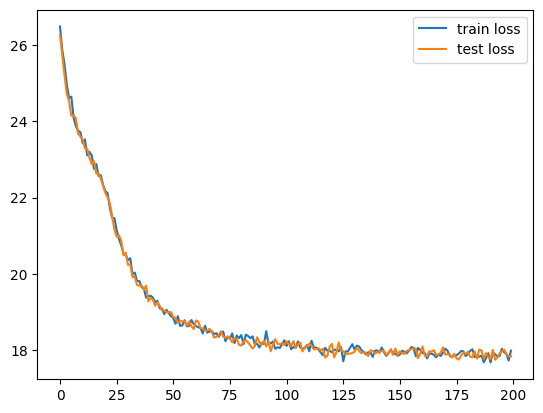

In [10]:
from matplotlib import pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)

plt.legend(["train loss", "test loss"])


## Visualizing Embeddings
Now, we can have a look at the embeddings that the model has learned.

In [11]:
embeddings = pd.DataFrame(skip_gram_model.embedding_matrix.data)
embeddings.head()

,0,1
0,1.087887,-0.568800
1,1.040954,-0.514612
2,1.520339,0.859559
3,0.062940,-1.395642
4,1.287691,-0.532036


Let's construct the inverse dictionary, to know what the entries correspond to:

In [12]:
inverse_dict = {v: k for k, v in frequent_word_dictionary.items()}
embeddings.index = [inverse_dict.get(i, "unknown") for i in range(len(embeddings))]
embeddings.head()

,0,1
,1.087887,-0.568800
dun,1.040954,-0.514612
re,1.520339,0.859559
lose,0.062940,-1.395642
opinion,1.287691,-0.532036


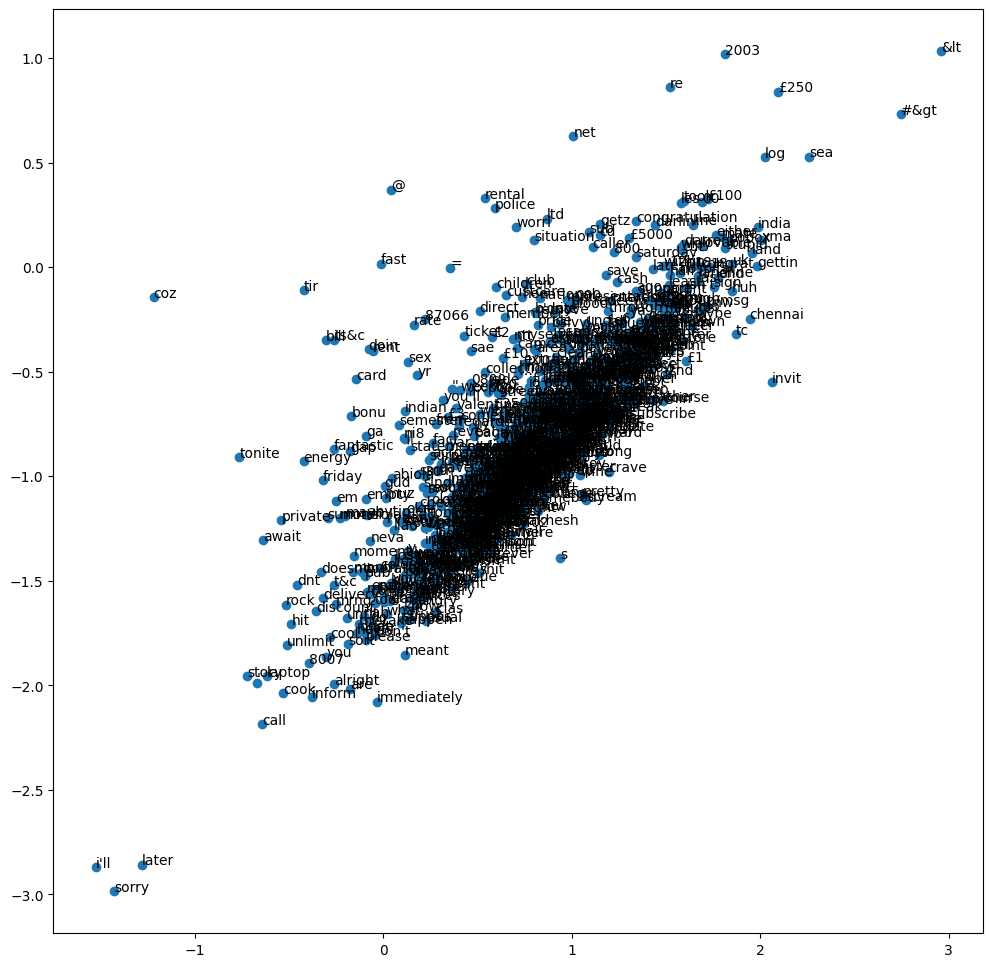

In [13]:
plt.figure(figsize=(12, 12))
plt.scatter(embeddings[0], embeddings[1])
for word, row in embeddings.iterrows():
    plt.text(row[0], row[1], word)

We see that the embeddings did not learn a lot of useful signal. The only thing that is consistently close to each other are the words "sorry", "i'll", "call", and "later".

This was somewhat to be expected:
- With 5'600 messages, our corpus is very small for natural language processing.
- Messages are very short, so we only have few words per document.
- Text quality is poor, since there are many typos, slang and abbreviation.

All of this means that we don't have many example usages for all of the words in our corpus. We therefore don't see them in enough situations to properly learn what context they are used in. The only exception is the combination sorry, call and later which is sufficiently abundant for our model to learn that these words are often used together.

## Bigger Embeddings
Let's see if using a bigger embedding size can improve our model.

In [14]:
embedding_size = 20

skip_gram_model = SkipGram(vocabulary_size + 1, embedding_size)
optimizer = torch.optim.AdamW(skip_gram_model.parameters())

n_epochs = 200
train_losses = []
val_losses = []

for i in range(n_epochs):
    # train during a single epoch
    train_loss_epoch = []
    for queries, targets in train_data_loader:
        optimizer.zero_grad()

        outputs = skip_gram_model(queries)

        loss = torch.nn.functional.cross_entropy(outputs, targets)
        loss.backward()
        train_loss_epoch.append(loss.item())

        optimizer.step()
        
    # validation run
    val_loss_epoch = []
    with torch.no_grad():
        for queries, targets in train_data_loader:
            outputs = skip_gram_model(queries)
            val_loss = torch.nn.functional.cross_entropy(outputs, targets)
            val_loss_epoch.append(val_loss)

    train_losses.append(sum(train_loss_epoch) / len(train_loss_epoch))
    val_losses.append(sum(val_loss_epoch) / len(val_loss_epoch))

Looking at the loss:

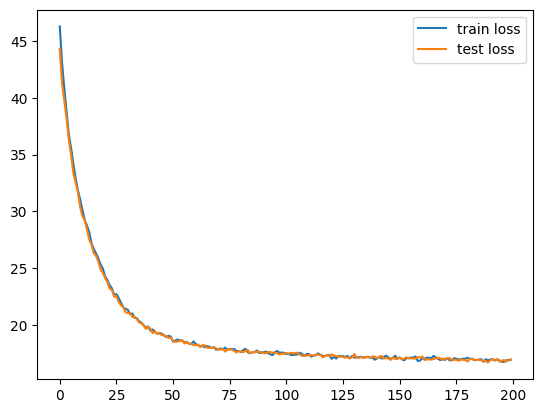

In [15]:
from matplotlib import pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)

plt.legend(["train loss", "test loss"])


In [16]:
val_losses[-1]

tensor(16.9623)

Using the larger model slightly improved the loss. However, it is not until we use the embedding on a downstream task that we see if our embedding is any good.